# PROYECTO FINAL - PREDICCIÓN DE TIPO DE BIEN DE PROPIEDAD HORIZONTAL
**Maestria en Inteligencia Artificial - Electiva 2** \
*Estudiante:* Germán Andrés Rojas Mahecha

## Caso de Negocio


**Contexto:** Uno de los requisitos de un proyecto inmobiliario para su escrituración y entrega a los propietarios finales es contar con una licencia de propiedad horizontal (PH). Este proceso consiste en el desarrollo de una serie de documentos técnicos donde se describe un proyecto arquitectonico bajo los criterios de la Ley 675 de 2001 que rige en Colombia la Propiedad Horizontal, y estos se radican ante Curaduría o Secretaría de Planeación según el municipio donde se ubique el proyecto. Estos documentos técnicos de PH son desarrollados por arquitectos especializados en el tema. \
**Problema específico a resolver**: La importancia de los documentos técnicos radica en establecer de manera precisa si cada uno de los espacios o áreas que comprenden el proyecto arquitectónico son Bienes Privados o Bienes Comunes. Este proceso de asignación se realiza de forma manual por parte de los arquitectos. El objetivo de este modelo de ML de clasificación es que basado en una serie de caracteristicas geometricas de cada uno de los bienes, predecir de si es un Bien Privado o un Bien Común, inicialmente como un apoyo en el proceso de control de calidad al realizar los documetnos técnicos de PH, y posteriormente para determinar de manera automatica la clasificación de cada Bien de un proyecto ante el input de un modelo tridimensional espacial no etiquetado.

## Contenido del Dataset

*El Dataset describe las caracteristicas geometricas mas importantes que describen a un elemento espacial de PH. A continuación se describen las caracteristicas:* \
**Area**: Superficie que cubre el elemento espacial expresada en m2. \
**Perimetro**: Suma de la longitud de todos sus lados expresada en m. \
**Cantidad_Vertices**: Número de vertices que conforman el poligono. A mayor cantidad de vertices mas irregular es el poligono. \
**Contornos_Internos**: Numero de "huecos" al interior del elemento espacial, indicando otros bienes que no son parte de su superficie asociada. \
**Nivel**: Altura en metros sobre el nivel 0 del terreno. Una altura negativa indica que el elemento se encuentra en un sótano, una altura entre 0 y 1.5 metros indica que se encuentra en el nivel de acceso del proyecto, y una altura superior a 1.5 metros indica que se encuentra en el Piso 2 o superior (requiere escalera o ascensor para acceder) \
**RMC_Largo**: Longitud en m (Lado en el eje X del plano orientado en la misma dirección del elemento) del Rectangulo Minimo que contiene al elemento espacial. \
**RMC_Alto**: Alto en m (Lado en el eje Y del plano orientado en la misma dirección del elemento) del Rectangulo Minimo que contiene al elemento espacial. \
**RMC_Ratio**: Relación entre el largo y el alto de del Rectangulo Minimo Contenedor. Expresado como un numero real \
**Tipo_Area_PH**: Categoría de Bien de PH. Caracteristica a predecir. (Privada/Común)


## Exploración y Análisis

In [172]:
# Cargar las librerias requeridas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

# Procesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Metricas de evaluacion
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import joblib

In [2]:
# Cargar el dataset
# df = pd.read_csv("s3://electiva2-proyecto-final/Data/spatial_elements_ph.csv", usecols=(lambda x: x != 'Objeto_rvt')) # for AWS
df = pd.read_csv("K:\Google Drive\Maestria en IA-Sergio Arboleda\Semestre II\Electiva II\Proyecto Final\spatial_elements_ph.csv", usecols=(lambda x: x != 'Objeto_rvt')) # for local

In [3]:
df

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
0,43.152,27.22,9,0,1.500,8.01,5.61,1.43,Privada
1,41.652,26.62,6,0,1.500,7.80,5.52,1.41,Privada
2,42.204,26.84,7,0,1.500,7.90,5.52,1.43,Privada
3,42.152,26.84,8,0,1.500,7.90,5.52,1.43,Privada
4,43.152,27.20,8,0,1.500,8.00,5.62,1.42,Privada
...,...,...,...,...,...,...,...,...,...
7987,32.584,122.46,30,0,29.880,6.79,5.99,1.13,Privada
7988,31.781,119.11,24,0,29.880,7.10,5.84,1.22,Privada
7989,27.561,85.07,22,0,50.531,6.50,5.66,1.15,Privada
7990,27.629,78.31,18,0,50.531,6.56,5.56,1.18,Privada


In [4]:
# Convertir la columna Tipo_Area_PH (Target) a una clasificación binaria
df['Tipo_Area_PH'] = df['Tipo_Area_PH'].apply(lambda x: 0 if x == "Privada" else 1)
df.head()

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
0,43.152,27.22,9,0,1.5,8.01,5.61,1.43,0
1,41.652,26.62,6,0,1.5,7.80,5.52,1.41,0
2,42.204,26.84,7,0,1.5,7.90,5.52,1.43,0
3,42.152,26.84,8,0,1.5,7.90,5.52,1.43,0
4,43.152,27.20,8,0,1.5,8.00,5.62,1.42,0


In [24]:
print("Privada: Cantidad Datos=", df['Tipo_Area_PH'].value_counts()[0], "Porcentaje del total=", round(df['Tipo_Area_PH'].value_counts()[0]/df['Tipo_Area_PH'].shape[0]*100, 2), "%")
print("Común: Cantidad Datos=", df['Tipo_Area_PH'].value_counts()[1], "Porcentaje del total=", round(df['Tipo_Area_PH'].value_counts()[1]/df['Tipo_Area_PH'].shape[0]*100, 2), "%")

Privada: Cantidad Datos= 5541 Porcentaje del total= 69.33 %
Común: Cantidad Datos= 2451 Porcentaje del total= 30.67 %


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7992 entries, 0 to 7991
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Area                  7992 non-null   float64
 1   perimetro             7992 non-null   float64
 2   Cantidad_Vertices     7992 non-null   int64  
 3   Contornos_Interiores  7992 non-null   int64  
 4   Nivel                 7992 non-null   float64
 5   RMC_Largo             7992 non-null   float64
 6   RMC_Alto              7992 non-null   float64
 7   RMC_Ratio             7992 non-null   float64
 8   Tipo_Area_PH          7992 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 562.1 KB


In [7]:
df.describe()

,Area,perimetro,Cantidad_Vertices,Contornos_Interiores,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
count,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000
mean,234.178494,56.431368,17.563188,0.258509,10.773884,11.459347,6.991767,2.753493,0.306682
std,1766.538488,83.237479,17.078412,3.351511,15.171983,23.275347,14.656829,7.065682,0.461145
min,0.110000,1.300000,3.000000,0.000000,-7.000000,0.360000,0.110000,1.000000,0.000000
25%,12.500000,20.275000,8.000000,0.000000,0.000000,5.850000,2.580000,1.170000,0.000000
50%,35.104000,30.260000,14.000000,0.000000,2.450000,7.710000,6.020000,1.440000,0.000000
75%,46.919000,41.390000,21.000000,0.000000,18.100000,9.350000,6.440000,1.980000,1.000000
max,59436.953000,997.710000,309.000000,127.000000,66.301000,337.580000,242.380000,241.670000,1.000000


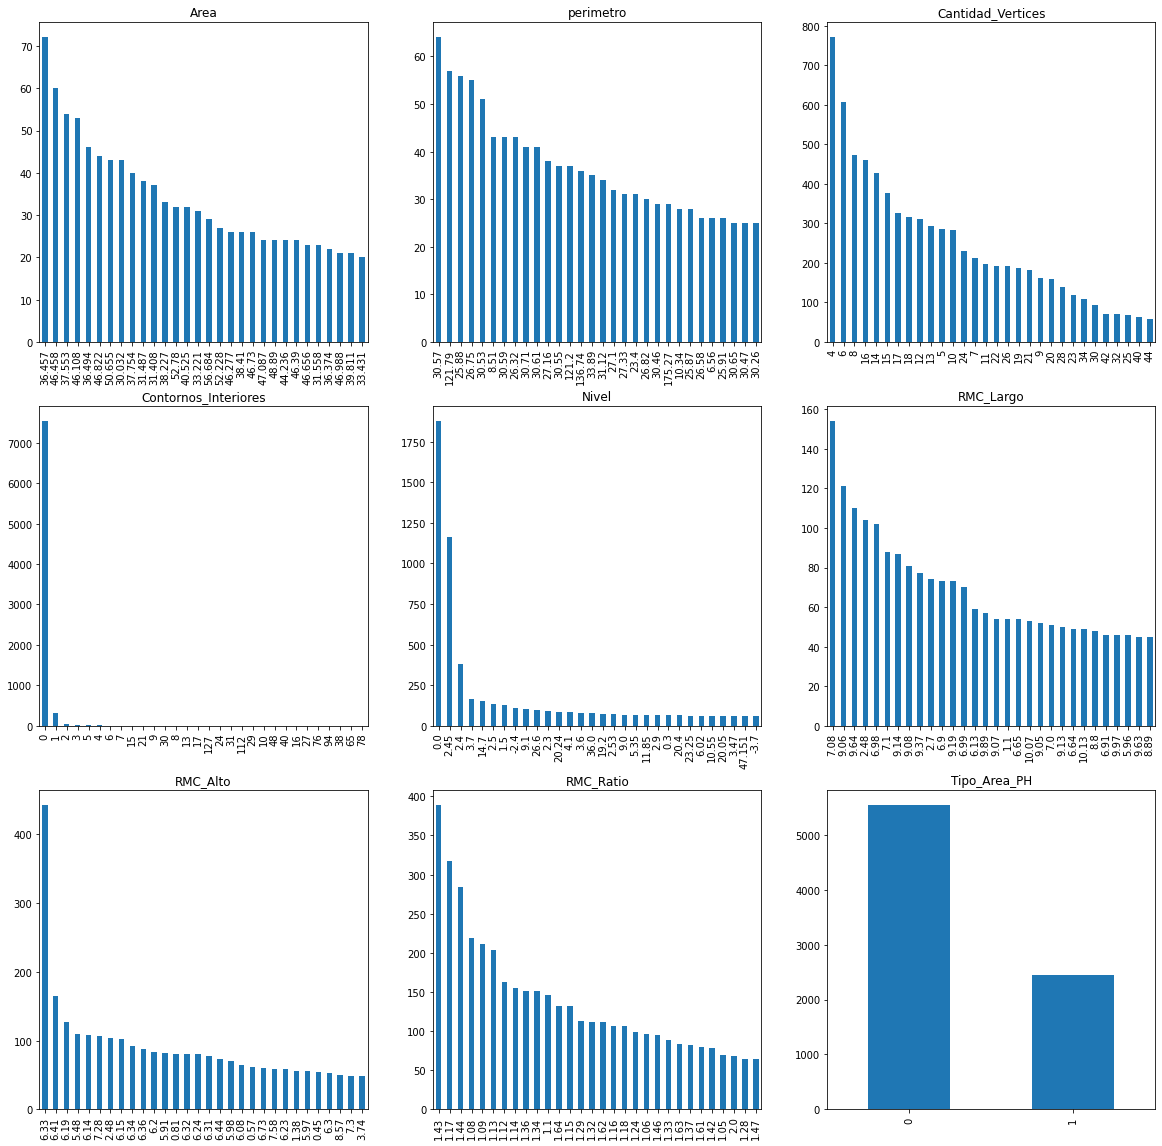

In [8]:
# Valores mas frecuentes
fig, ax = plt.subplots(3, 3)
for ind, feature in enumerate(df.columns):
    df[feature].value_counts().nlargest(30).plot(ax=ax[math.floor(ind/3), ind%3],kind='bar', figsize=(20, 20), title=feature)

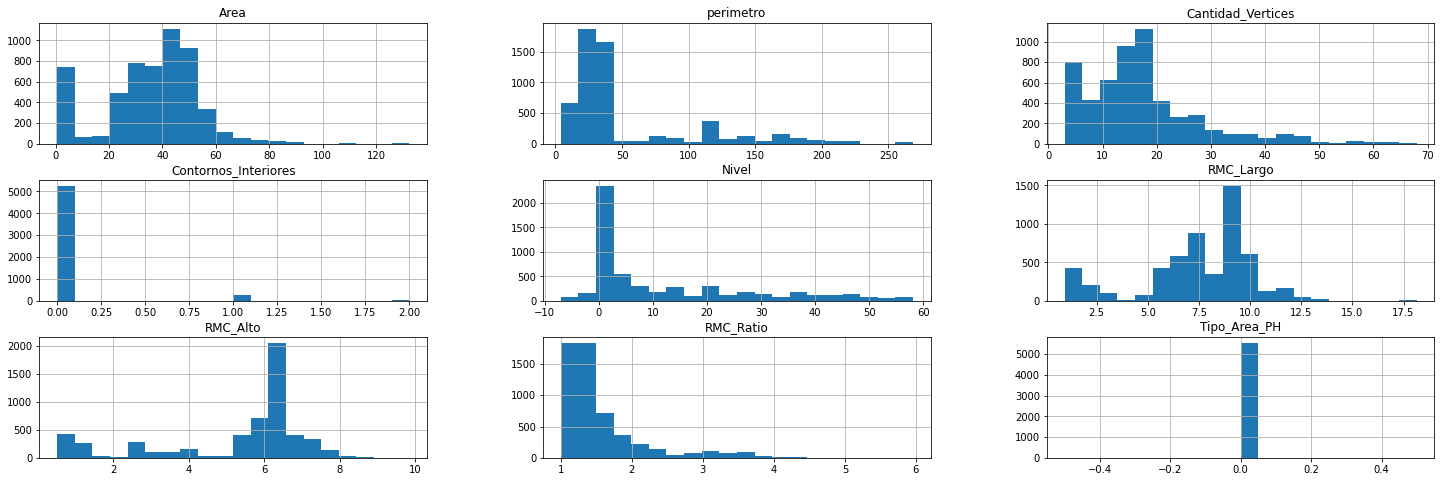

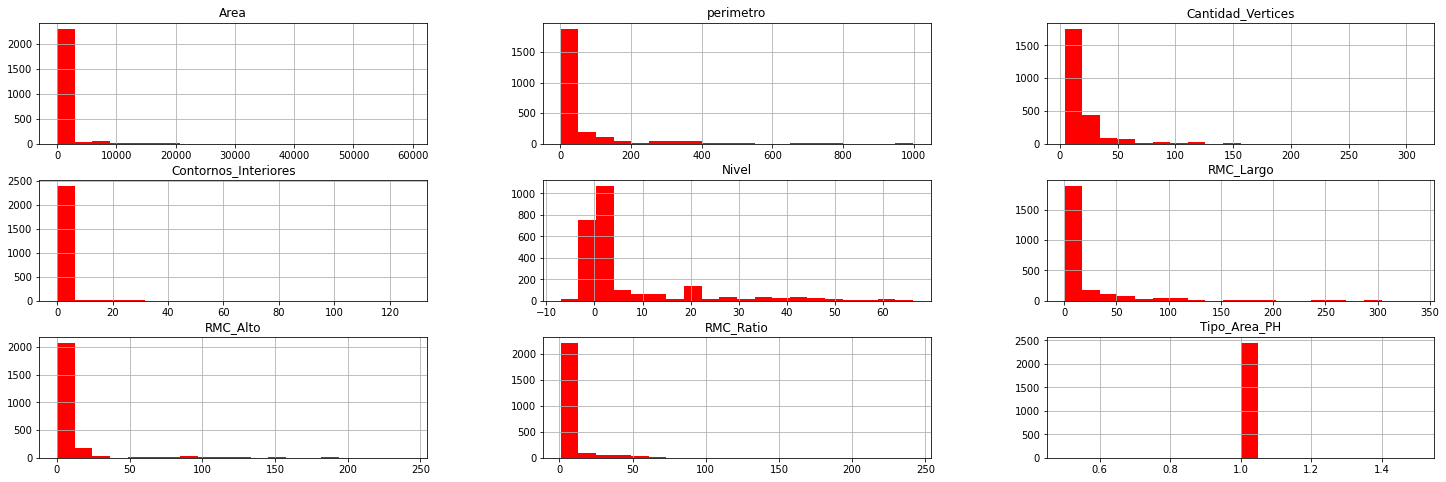

In [9]:
df[df['Tipo_Area_PH'] == 0].hist(bins=20, figsize=(25, 8))
df[df['Tipo_Area_PH'] == 1].hist(bins=20, figsize=(25, 8), color='r')
plt.show()

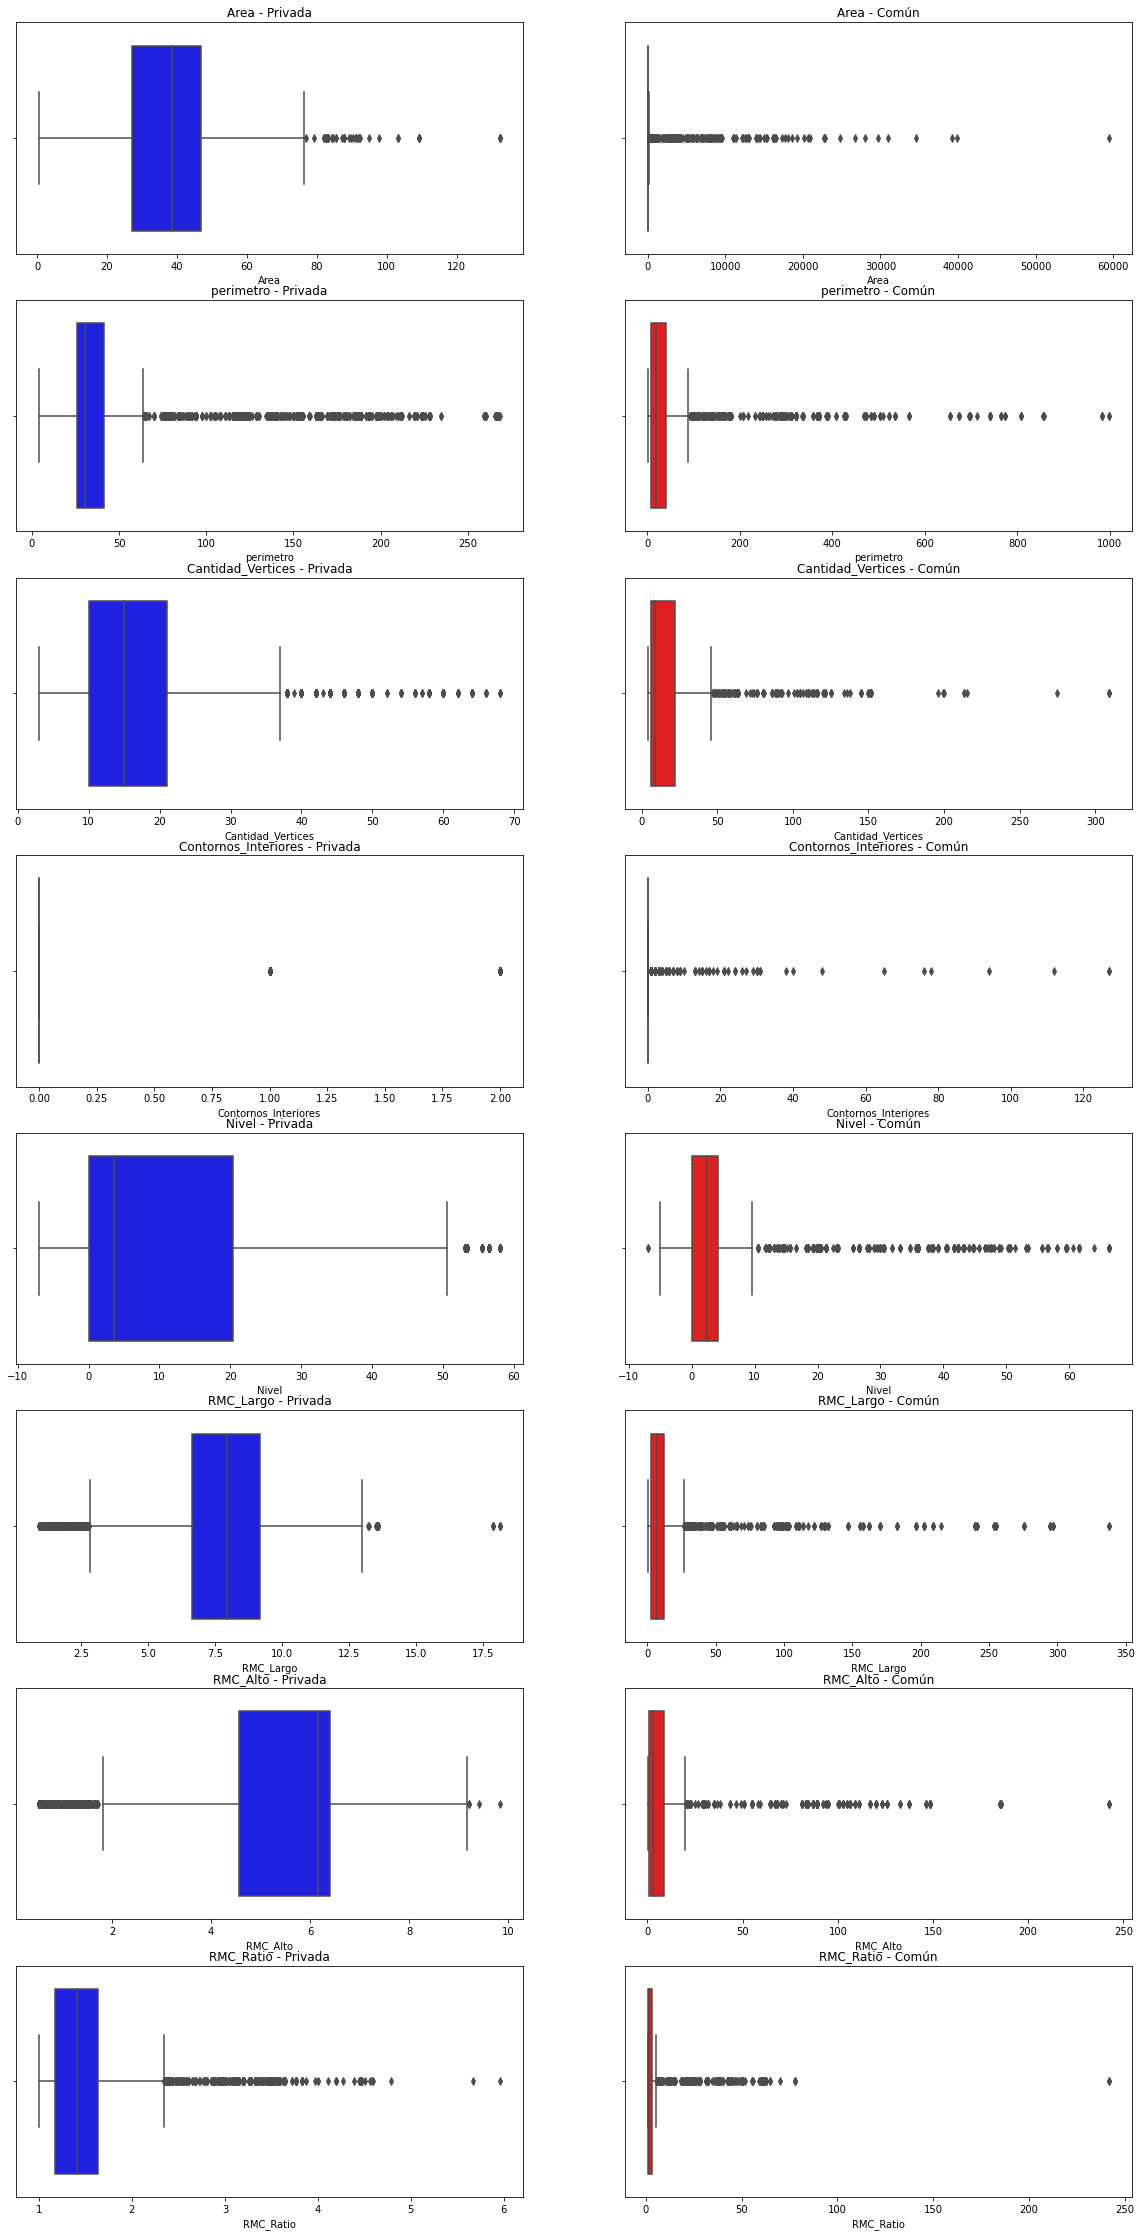

In [10]:
# Revisar la distribución y los valores atípicos
fig, ax = plt.subplots(len(df.columns)-1, 2, figsize=(20, 40))
for ind, feature in enumerate(df.columns):
    if feature != 'Tipo_Area_PH':
        sns.boxplot(x=df[df['Tipo_Area_PH'] == 0][feature], ax=ax[ind, 0], color='b')
        sns.boxplot(x=df[df['Tipo_Area_PH'] == 1][feature], ax=ax[ind, 1], color='r')
        ax[ind, 0].set_title(feature + ' - Privada')
        ax[ind, 1].set_title(feature + ' - Común')

plt.show()

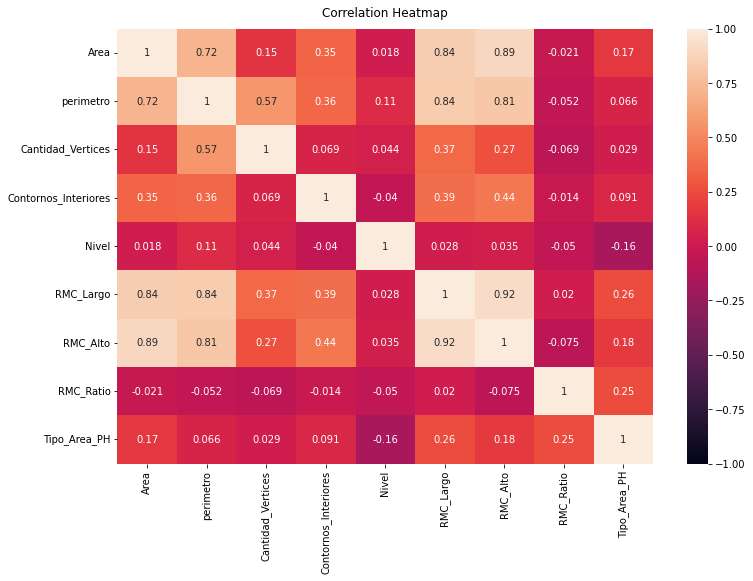

In [11]:
# Correlación
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

**Comentarios:**
- El dataset se compone de caracteristicas geometricas expresadas todas de forma numerica, y no hay nulos presentes debido a que la información del dataset es extraida de un sistema de información donde hay reglas de validación estrictas de acuerdo a la lógica de negocio de un proyecto de PH. \
- Hay diferencias importantes en la distribución de los datos de la variable target: Aunque ambas cateogrías son sesgadas hacia los valores bajos del rango en la mayoría de caracteristicas, en el caso de la Categoría Común (1) hay una gran cantidad de valores atipicos y el rango de los valores es muy amplio. \
- El Dataset esta un poco desbalanceado hacia la categoría Privada (0) con un 69.33% del total de datos respecto a la categoría Común (1) con un 30.67%. Esta proporción es habitual en los proyectos de PH. \
- Ninguna caracteristica muestra una correlación importante con la variable target, solo algunas caracteristicas como las relacionadas al RMC y el Área presentan una correlación leve.
- Entre las caracteristicas si se presentan correlaciones intrinsecas fuertes, algo esperable debido a que todas se refieren a aspectos geometricos y espaciales del bien.

## Selección de Variables

### Metodo de Permutation Feature Importance

In [40]:
# Dividir el dataset en train y test
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Tipo_Area_PH"])
_train, val = train_test_split(train, test_size=0.3, random_state=42, stratify=train["Tipo_Area_PH"])

X_train = _train.drop('Tipo_Area_PH', axis=1)
y_train = _train['Tipo_Area_PH']
X_val = val.drop('Tipo_Area_PH', axis=1)
y_val = val['Tipo_Area_PH']

#### Modelo 1: Decision Tree Classifier

In [45]:
# Modelo Decision Tree
dtc_pfi = DecisionTreeClassifier()
dtc_pfi.fit(X_train, y_train)

DecisionTreeClassifier()

In [46]:
print("Precisión: ", accuracy_score(y_val, dtc_pfi.predict(X_val)))

Precisión:  0.9827278141751042


In [67]:
r_dtc = permutation_importance(dtc_pfi, X_val, y_val, n_repeats=50)

<function matplotlib.pyplot.show(close=None, block=None)>

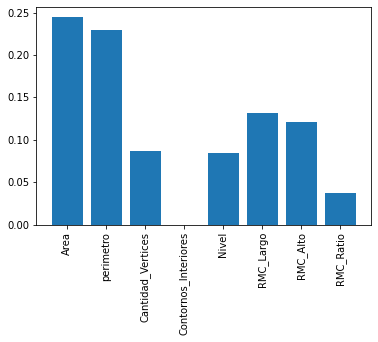

In [68]:
plt.bar(x=X_train.columns, height=r_dtc['importances_mean'])
plt.xticks(rotation=90)
plt.show

#### Modelo 2: Logistic Regression

In [69]:
# Se debe escalar los datos para el modelo de regresión logística
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_val_scaled = MinMaxScaler().fit_transform(X_val)

In [70]:
# Modelo Regresión Logística
rl_pfi = LogisticRegression()
rl_pfi.fit(X_train_scaled, y_train)

LogisticRegression()

In [71]:
print("Precisión: ", accuracy_score(y_val, rl_pfi.predict(X_val)))

Precisión:  0.5824895771292437


c:\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [72]:
r_rl = permutation_importance(rl_pfi, X_val_scaled, y_val, n_repeats=50)

<function matplotlib.pyplot.show(close=None, block=None)>

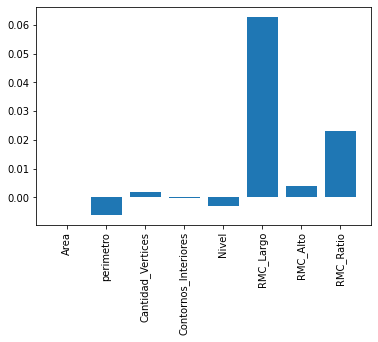

In [73]:
plt.bar(x=X_train.columns, height=r_rl['importances_mean'])
plt.xticks(rotation=90)
plt.show

#### Caracteristicas Seleccionadas

Tras analizar la correlación y la importancia de las caracteristicas bajo el metodo de Permutation Feature Importance, especialmente el del Modelo de Arbol de Decisión que tuvo mejor desempeño que el de Regresión Logistica, se decide excluir la variable *Contornos_Interiores* que parece no aportar nada al momento de clasificar el Bien.


In [81]:
caracteristicas_seleccionadas = ['Area', 'perimetro', 'Cantidad_Vertices', 'Nivel', 'RMC_Largo', 'RMC_Alto', 'RMC_Ratio', 'Tipo_Area_PH']

## Creación de Modelo

#### Dataset para entrenamiento

In [124]:
df_final = df[caracteristicas_seleccionadas]
df_final.head()

,Area,perimetro,Cantidad_Vertices,Nivel,RMC_Largo,RMC_Alto,RMC_Ratio,Tipo_Area_PH
0,43.152,27.22,9,1.5,8.01,5.61,1.43,0
1,41.652,26.62,6,1.5,7.80,5.52,1.41,0
2,42.204,26.84,7,1.5,7.90,5.52,1.43,0
3,42.152,26.84,8,1.5,7.90,5.52,1.43,0
4,43.152,27.20,8,1.5,8.00,5.62,1.42,0


In [125]:
train, test = train_test_split(df_final, test_size=0.3, random_state=42, stratify=df["Tipo_Area_PH"])
X_train = train.drop("Tipo_Area_PH", axis=1)
y_train = train["Tipo_Area_PH"]

#### Modelos de Clasificación

In [126]:
# Modelo Decision Tree
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [127]:
# Modelo Regresión Logística
model_rl = LogisticRegression()
model_rl.fit(X_train, y_train)

LogisticRegression()

In [128]:
# Modelo Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [129]:
# Modelo SVM
model_svm = svm.SVC()
model_svm.fit(X_train, y_train)

SVC()

## Creación de Pipeline

Solo se requiere un pipeline para variables numericas teniendo en cuenta las caracteristicas del dataset. Aunque en los datos para el entrenamiento del modelo no se encuentran nulos, se prevee la imputación con la media

In [130]:
numeric_pipeline = Pipeline(
    [
        ("Imputación con la media", SimpleImputer(strategy="mean")),
        ("Escalado", MinMaxScaler()),
    ]
)

In [131]:
columns_transformer = ColumnTransformer(
    [
        ("numeric", numeric_pipeline, X_train.columns),
    ]
)

## Evaluación de Modelos

#### Validación Cruzada

In [140]:
def results_cv(results):
    print("train: accuracy=", round(results['train_accuracy'].mean(), 3), "+-", round(results["train_accuracy"].std(), 3), "/", "f1=", round(results['train_f1'].mean(), 3), "+-", round(results["train_f1"].std(), 3))
    print("validation: accuracy=", round(results['test_accuracy'].mean(), 3), "+-", round(results["test_accuracy"].std(), 3), "/", "f1=", round(results['test_f1'].mean(), 3), "+-", round(results["test_f1"].std(), 3))

##### Arbol de Decisión

In [141]:
validation_pipeline_dtc = Pipeline(
    [
        ("Pipeline de preprocesamiento", columns_transformer),
        ("Modelo de predicción (Árbol de Decisión)", model_dtc)
    ]
)

In [142]:
results_dtc = cross_validate(validation_pipeline_dtc,
                        X_train, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [143]:
results_cv(results_dtc)

train: accuracy= 1.0 +- 0.0 / f1= 1.0 +- 0.0
validation: accuracy= 0.988 +- 0.004 / f1= 0.98 +- 0.006


##### Regresión Logisitica

In [144]:
validation_pipeline_rl = Pipeline(
    [
        ("Pipeline de preprocesamiento", columns_transformer),
        ("Modelo de predicción (Regresión Logistica)", model_rl)
    ]
)

In [145]:
results_rl = cross_validate(validation_pipeline_rl,
                        X_train, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [146]:
results_cv(results_rl)

train: accuracy= 0.752 +- 0.002 / f1= 0.32 +- 0.01
validation: accuracy= 0.752 +- 0.007 / f1= 0.32 +- 0.03


##### Random Forest

In [147]:
validation_pipeline_rf = Pipeline(
    [
        ("Pipeline de preprocesamiento", columns_transformer),
        ("Modelo de predicción (Regresión Logistica)", model_rf)
    ]
)

In [148]:
results_rf = cross_validate(validation_pipeline_rf,
                        X_train, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [149]:
results_cv(results_rf)

train: accuracy= 1.0 +- 0.0 / f1= 1.0 +- 0.0
validation: accuracy= 0.992 +- 0.002 / f1= 0.987 +- 0.004


##### SVM

In [150]:
validation_pipeline_svm = Pipeline(
    [
        ("Pipeline de preprocesamiento", columns_transformer),
        ("Modelo de predicción (Regresión Logistica)", model_svm)
    ]
)

In [151]:
results_svm = cross_validate(validation_pipeline_svm,
                        X_train, y_train, cv=10,
                         return_train_score=True,
                         scoring=["accuracy", "f1"]
                        )

In [152]:
results_cv(results_svm)

train: accuracy= 0.821 +- 0.003 / f1= 0.593 +- 0.012
validation: accuracy= 0.819 +- 0.008 / f1= 0.588 +- 0.026


#### Resultados

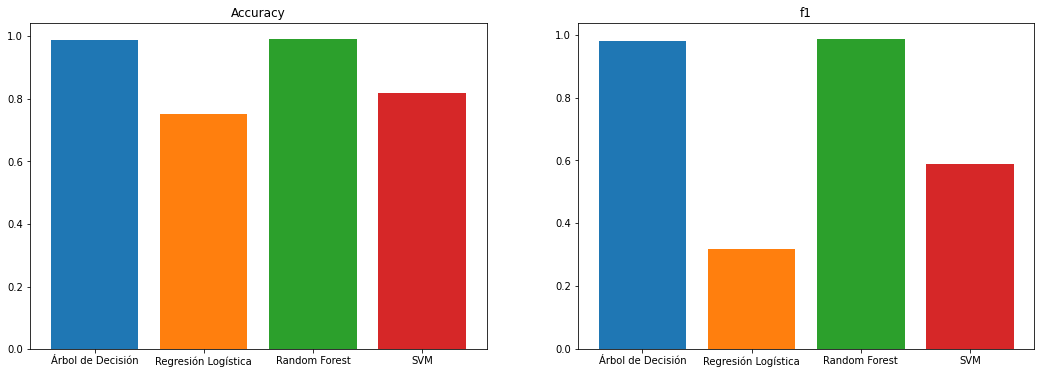

In [171]:
#plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].bar(x=["Árbol de Decisión", "Regresión Logística", "Random Forest", "SVM"], height=[results_dtc['test_accuracy'].mean(), results_rl['test_accuracy'].mean(), results_rf['test_accuracy'].mean(), results_svm['test_accuracy'].mean()], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
ax[0].set_title("Accuracy")

ax[1].bar(x=["Árbol de Decisión", "Regresión Logística", "Random Forest", "SVM"], height=[results_dtc['test_f1'].mean(), results_rl['test_f1'].mean(), results_rf['test_f1'].mean(), results_svm['test_f1'].mean()], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
ax[1].set_title("f1")
plt.show()

El modelo con mejor rendimiento es Random Forest, y es seleccionado como el modelo para ajustar y desplegar.

## Ajuste de Hiperparámetros

In [181]:
grid = {'max_depth': [2,3,4,5], 'n_estimators': [50, 100, 200]}

In [182]:
#Preprocesar ya que no se puede pasar el pipeline al gridsearch
X_transformed = columns_transformer.fit_transform(X_train)

In [183]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid=grid,
    cv=10,
    scoring="accuracy"
)

In [184]:
grid_search.fit(X_transformed, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [185]:
print("Mejor Configuración: ", grid_search.best_params_)
print("Mejor performance: ", grid_search.best_score_)

Mejor Configuración:  {'max_depth': 5, 'n_estimators': 100}
Mejor performance:  0.9601351265014054


## Modelo Final

In [186]:
final_pipeline_bestmodel = Pipeline(
    [
        ("Pipeline de preprocesamiento", columns_transformer),
        ("Modelo de predicción (Árbol)", RandomForestClassifier(max_depth=5, n_estimators=100))
    ]
)

In [188]:
X_train_best_model = train[caracteristicas_seleccionadas]

In [189]:
final_pipeline_bestmodel.fit(X_train_best_model, y_train)

Pipeline(steps=[('Pipeline de preprocesamiento',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Imputación '
                                                                   'con la '
                                                                   'media',
                                                                   SimpleImputer()),
                                                                  ('Escalado',
                                                                   MinMaxScaler())]),
                                                  Index(['Area', 'perimetro', 'Cantidad_Vertices', 'Nivel', 'RMC_Largo',
       'RMC_Alto', 'RMC_Ratio'],
      dtype='object'))])),
                ('Modelo de predicción (Árbol)',
                 RandomForestClassifier(max_depth=5))])

## Creación de Joblib

In [190]:
filename = 'final_model.joblib'
joblib.dump(final_pipeline_bestmodel, filename)

['final_model.joblib']

In [191]:
!tar -zcvf model.tar.gz final_model.joblib

a final_model.joblib
